In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import HillClimbSearch, BIC
# from pgmpy.models import BayesianNetwor
from pgmpy.models import DiscreteBayesianNetwork

### 1. Statistic Description

In [6]:
df = pd.read_csv('demo_ridership_monthly.csv')
print(df.head())

     month  station_complex_id               fare_class_category  ridership  \
0  2023-01                   1             Metrocard - Fair Fare       5273   
1  2023-01                   1             Metrocard - Full Fare      60696   
2  2023-01                   1                 Metrocard - Other      13501   
3  2023-01                   1  Metrocard - Seniors & Disability       8090   
4  2023-01                   1              Metrocard - Students      15037   

   Complex_ID   Latitude  Longitude  MEAN_Median_Inc  SUM_Total_Popu  \
0           1  40.775036 -73.912034         107187.3           30146   
1           1  40.775036 -73.912034         107187.3           30146   
2           1  40.775036 -73.912034         107187.3           30146   
3           1  40.775036 -73.912034         107187.3           30146   
4           1  40.775036 -73.912034         107187.3           30146   

   SUM_Male_Total  SUM_Female_Tot  SUM_White_Alon  SUM_Black_Alon  \
0           15089      

In [16]:
print(df.dtypes)

month                   object
station_complex_id       int64
fare_class_category     object
ridership                int64
Complex_ID               int64
Latitude               float64
Longitude              float64
MEAN_Median_Inc        float64
SUM_Total_Popu           int64
SUM_Male_Total           int64
SUM_Female_Tot           int64
SUM_White_Alon           int64
SUM_Black_Alon           int64
SUM_Hispanic_L           int64
SUM_Non_Hispan           int64
dtype: object


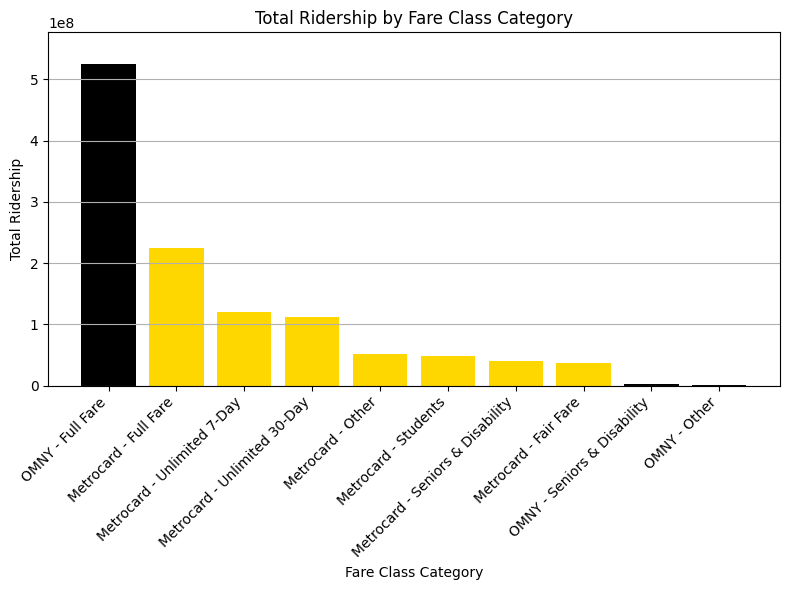

In [7]:
# Aggregate over 'fare_class_category'
ridership_by_fare_class = df.groupby('fare_class_category')['ridership'].sum().sort_values(ascending=False)

# Prepare data
x = np.arange(len(ridership_by_fare_class))
y = ridership_by_fare_class.values
labels = ridership_by_fare_class.index

# Set color
colors = []
for label in labels:
    if label.startswith('OMNY'):
        colors.append('black')
    elif label.startswith('Metrocard'):
        colors.append('gold')
    else:
        colors.append('gray')

# Plot
plt.figure(figsize=(8, 6))  # Increased figure height to provide more space
bars = plt.bar(x, y, color=colors)
plt.title('Total Ridership by Fare Class Category')
plt.xlabel('Fare Class Category')
plt.ylabel('Total Ridership')
plt.xticks(x, labels, rotation=45, ha='right')  # Ensure the x-labels are correctly aligned with bars
plt.grid(axis='y')

# Adjust the y-axis limit to ensure smaller values are visible
plt.ylim(0, max(y) * 1.1)  # Extend the y-axis by 10%

plt.tight_layout()
plt.show()

### 2. Bayesian Network

In [23]:
# cleaning the category
# Print all unique values of 'fare_class_category'
unique_fare_class_categories = df['fare_class_category'].unique()
print(unique_fare_class_categories)

['Metrocard - Fair Fare' 'Metrocard - Full Fare' 'Metrocard - Other'
 'Metrocard - Seniors & Disability' 'Metrocard - Students'
 'Metrocard - Unlimited 30-Day' 'Metrocard - Unlimited 7-Day'
 'OMNY - Full Fare' 'OMNY - Other' 'OMNY - Seniors & Disability']


In [24]:
df.columns

Index(['month', 'station_complex_id', 'fare_class_category', 'ridership',
       'Complex_ID', 'Latitude', 'Longitude', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan'],
      dtype='object')

In [12]:
df['income_level'] = pd.qcut(df['MEAN_Median_Inc'], q=3, labels=['Low', 'Medium', 'High'])

df['male_ratio'] = df['SUM_Male_Total'] / df['SUM_Total_Popu']
df['male_level'] = pd.cut(df['male_ratio'], bins=[0, 0.48, 0.52, 1.0], labels=['More Female', 'Balanced', 'More Male'])

df['hispanic_ratio'] = df['SUM_Hispanic_L'] / df['SUM_Total_Popu']
df['hispanic_level'] = pd.cut(df['hispanic_ratio'], bins=[0, 0.1, 0.3, 1.0], labels=['Low', 'Medium', 'High'])

In [7]:
# discrete variables
discrete_vars = df[['income_level', 'male_level', 'hispanic_level', 'fare_class_category']].dropna()

hc = HillClimbSearch(discrete_vars)
best_model = hc.estimate(scoring_method=BIC(discrete_vars))

model = DiscreteBayesianNetwork(best_model.edges())
model.fit(discrete_vars)

  0%|          | 0/1000000 [00:00<?, ?it/s]

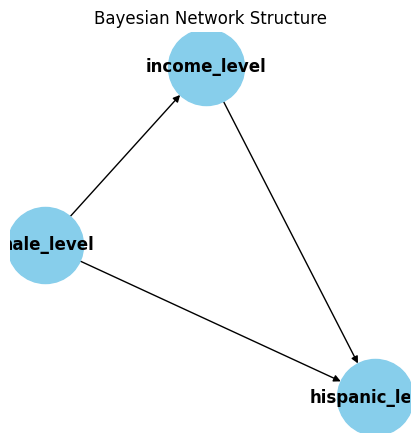

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork

G = nx.DiGraph()

# edges
edges = best_model.edges()
G.add_edges_from(edges)

# plot
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', arrows=True)
plt.title('Bayesian Network Structure')
plt.show()

### 3. Stack Bar Plot

#### 3.1 income

<ipython-input-36-ed7239206a17>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_fare_group = df.groupby(['income_level', 'fare_class_category'])['ridership'].sum().unstack()


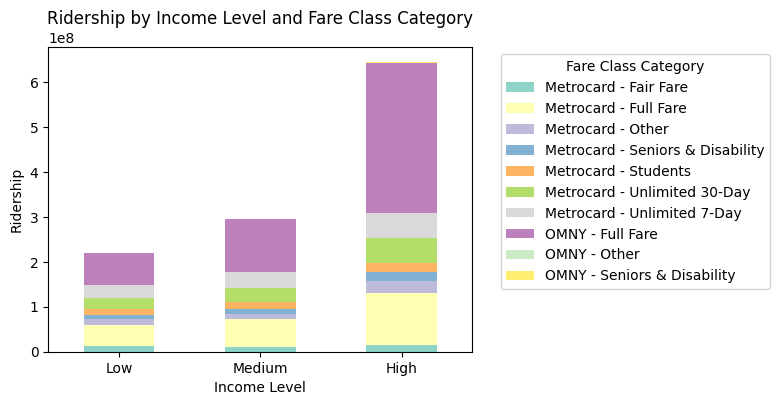

In [36]:
# Step 1: discrete the income data
df['income_level'] = pd.qcut(df['MEAN_Median_Inc'], q=3, labels=['Low', 'Medium', 'High'])

# Step 2: aggregate ridership under different income
income_fare_group = df.groupby(['income_level', 'fare_class_category'])['ridership'].sum().unstack()

# Step 3: plot
income_fare_group.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Set3')

plt.title('Ridership by Income Level and Fare Class Category')
plt.xlabel('Income Level')
plt.ylabel('Ridership')
plt.xticks(rotation=0)
plt.legend(title='Fare Class Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 3.2 gender

<ipython-input-13-3a037fc5a0f9>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_fare_group = df.groupby(['male_level', 'fare_class_category'])['ridership'].sum().unstack()


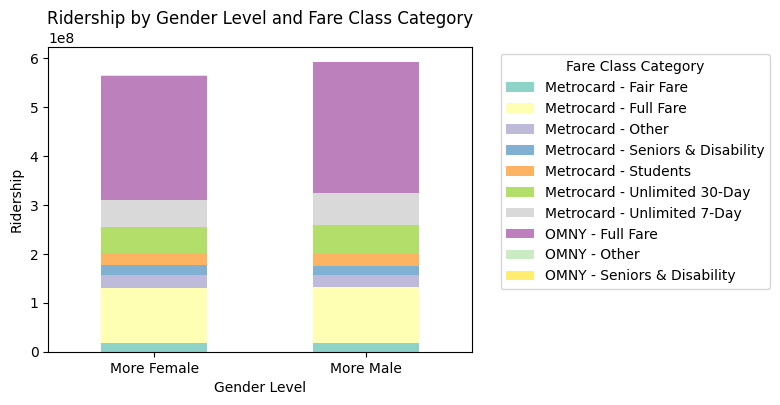

In [13]:
# Step 1
df['male_level'] = pd.cut(df['male_ratio'], bins=[0, 0.48, 1.0], labels=['More Female', 'More Male'])

# Step 2
gender_fare_group = df.groupby(['male_level', 'fare_class_category'])['ridership'].sum().unstack()

# Step 3
gender_fare_group.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Set3')

plt.title('Ridership by Gender Level and Fare Class Category')
plt.xlabel('Gender Level')
plt.ylabel('Ridership')
plt.xticks(rotation=0)
plt.legend(title='Fare Class Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### 3.3 race

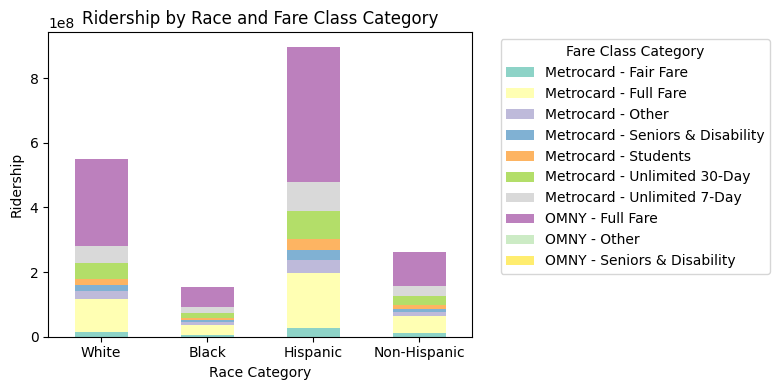

In [22]:
# Step 1
df['total_population'] = df['SUM_Total_Popu']
df['white_ratio'] = df['SUM_White_Alon'] / df['total_population']
df['black_ratio'] = df['SUM_Black_Alon'] / df['total_population']
df['hispanic_ratio'] = df['SUM_Hispanic_L'] / df['total_population']
df['non_hispanic_ratio'] = df['SUM_Non_Hispan'] / df['total_population']

# Step 2
df['white_ridership'] = df['white_ratio'] * df['ridership']
df['black_ridership'] = df['black_ratio'] * df['ridership']
df['hispanic_ridership'] = df['hispanic_ratio'] * df['ridership']
df['non_hispanic_ridership'] = df['non_hispanic_ratio'] * df['ridership']

# Step 3
race_fare_group = df.groupby(['fare_class_category'])[['white_ridership', 'black_ridership', 'hispanic_ridership', 'non_hispanic_ridership']].sum()

# Step 4
race_fare_group = race_fare_group.T

# Step 5
race_fare_group.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Set3')

plt.title('Ridership by Race and Fare Class Category')
plt.xlabel('Race Category')
plt.ylabel('Ridership')
plt.xticks(rotation=0)
plt.xticks([0, 1, 2, 3], ['White', 'Black', 'Hispanic', 'Non-Hispanic'], rotation=0)
plt.legend(title='Fare Class Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()